# Отчёт по лабораторной работе №1 "Логистическая регрессия в качестве нейронной сети"

**Данные:** В работе предлагается использовать набор данных notMNIST, который состоит из изображений размерностью 28×28 первых 10 букв латинского алфавита (A … J, соответственно). Обучающая выборка содержит порядка 500 тыс. изображений, а тестовая – около 19 тыс.

**Данные можно скачать по ссылке:**
- https://commondatastorage.googleapis.com/books1000/notMNIST_large.tar.gz (большой набор данных);
- https://commondatastorage.googleapis.com/books1000/notMNIST_small.tar.gz (маленький набор данных);

Описание данных на английском языке доступно по ссылке:
- http://yaroslavvb.blogspot.sg/2011/09/notmnist-dataset.html


### 1. Загрузите данные и отобразите на экране несколько из изображений с помощью языка Python;

In [17]:
import os
from scipy.io import loadmat
import numpy as np
import pathlib

data_dir = pathlib.Path('./Datasets/loaded_data/1-3/notMNIST_large')
dataset_dir = './Datasets/1-3'
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])
CLASS_NAMES.sort()

dataset = loadmat(f'{dataset_dir}/notMNIST_large.mat')

In [18]:
X = dataset['images']
Y = dataset['labels'][0]

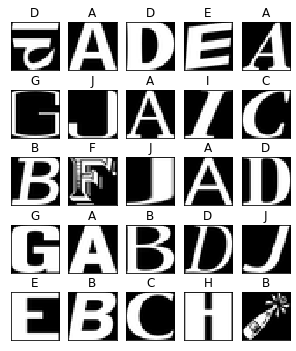

In [19]:
import numpy as np
import matplotlib.pyplot as plt

random_ids = np.random.choice(X.shape[0], 25, replace=False)
fig, axs = plt.subplots(5, 5, figsize=(5, 6))
axs = axs.flatten()

for i, random_id in enumerate(random_ids):
    image = X[random_id, :, :]
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(CLASS_NAMES[int(Y[random_id])])
    axs[i].xaxis.set_visible(False)
    axs[i].yaxis.set_visible(False)

plt.show()

### 2. Проверьте, что классы являются сбалансированными, т.е. количество изображений, принадлежащих каждому из классов, примерно одинаково (В данной задаче 10 классов).

In [20]:
from collections import Counter

label_counts = Counter(Y)
print(label_counts)

Counter({7.0: 52912, 5.0: 52912, 4.0: 52912, 8.0: 52912, 2.0: 52912, 6.0: 52912, 3.0: 52911, 9.0: 52911, 1.0: 52910, 0.0: 52909})


Максимальная разница между классами равно 3 изображениям. По сравнению со количеством изображений в одном классе это мелочи. Следовательно, классы сбалансированы.

### 3. Разделите данные на три подвыборки: обучающую (200 тыс. изображений), валидационную (10 тыс. изображений) и контрольную (тестовую) (19 тыс. изображений);


In [21]:
start = 0
unique_keys = []
for i, count in enumerate(label_counts.values()):
    unique_keys.append(len(Counter(Y[start:start + count]).keys()) == 1)
    start += count

print(unique_keys)

[True, True, True, True, True, True, True, True, True, True]


Следовательно, наш датасет отсортирован

In [22]:
labels_dict = {}
start = 0
for key, count in label_counts.items():
    labels_dict[key] = range(start, start + count)
    start += count

print(labels_dict)

{7.0: range(0, 52912), 5.0: range(52912, 105824), 4.0: range(105824, 158736), 8.0: range(158736, 211648), 3.0: range(211648, 264559), 1.0: range(264559, 317469), 0.0: range(317469, 370378), 9.0: range(370378, 423289), 2.0: range(423289, 476201), 6.0: range(476201, 529113)}


In [23]:
def create_dataset(length):
    temp_dataset = None
    count = int(length / len(labels_dict.keys()))
    for key, value in labels_dict.items():
        if temp_dataset is not None:
            temp_dataset = np.concatenate([temp_dataset, np.random.choice(value, count, replace=False)])
        else:
            temp_dataset = np.random.choice(value, count, replace=False)

    return temp_dataset

training_dataset = create_dataset(200000)
validation_dataset = create_dataset(10000)
test_dataset = create_dataset(19000)

### 4. Проверьте, что данные из обучающей выборки не пересекаются с данными из валидационной и контрольной выборок. Другими словами, избавьтесь от дубликатов в обучающей выборке.


In [24]:
training_dataset = np.array(list(set(training_dataset) - set(test_dataset) - set(validation_dataset)))


print('training_dataset_counter:', Counter(Y[training_dataset.tolist()]))

training_dataset_counter: Counter({6.0: 18964, 3.0: 18958, 9.0: 18931, 7.0: 18930, 8.0: 18928, 0.0: 18928, 1.0: 18926, 5.0: 18923, 4.0: 18911, 2.0: 18876})


In [25]:
import pandas as pd


def save_data(X, Y, dataset_type):
    df = pd.DataFrame().append([{'X': X, 'Y': Y}])
    df.to_pickle(f'{dataset_dir}/{dataset_type}.pkl')

save_data(X[training_dataset, :, :], Y[training_dataset], 'training')
save_data(X[validation_dataset, :, :], Y[validation_dataset], 'validation')
save_data(X[test_dataset, :, :], Y[test_dataset], 'test')

### 5. Постройте простейший классификатор (например, с помощью логистической регрессии). Постройте график зависимости точности классификатора от размера обучающей выборки (50, 100, 1000, 50000). Для построения классификатора можете использовать библиотеку SkLearn (http://scikit-learn.org).

In [26]:
image_dataset = X.reshape((529113, 28*28))

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
def get_score(dataset_len):
    temp_dataset = np.random.choice(training_dataset, dataset_len, replace=False)
    clf = LogisticRegression(solver='lbfgs', random_state=0, verbose=2, n_jobs=3, multi_class='auto')
    clf.fit(image_dataset[temp_dataset, :], Y[temp_dataset])
    return clf.score(image_dataset[test_dataset, :], Y[test_dataset])

In [29]:
datasets_lens = [50, 100, 1000, 50000]
datasets_scores = [get_score(length) for length in datasets_lens]
print(datasets_scores)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    3.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


[0.5491578947368421, 0.6666315789473685, 0.7548947368421053, 0.8234736842105264]


[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:   18.4s finished


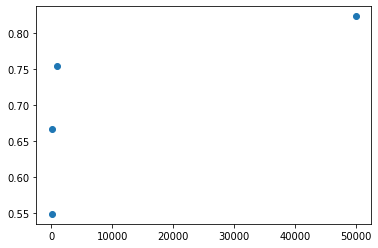

In [30]:
import matplotlib.pyplot as plt

plt.plot(datasets_lens, datasets_scores, 'o')